# I. Lý thuyết

1) Mạng tích chập CNN sẽ được thực hiện như thế nào?

Đáp án:

D. Di chuyển vùng local receptive field theo chiều từ trái sang phải và từ trên xuống dưới và nhân tích chập với kernel để thu được ma trận feature map.

2) Thực hiện phép nhân tích chập giữa ma trận đầu vào kích thước width và height lần lượt là $(W, H)$ với bộ lọc kích thước $(F, F)$ và bước nhảy $S$ thì thu được ma trận đầu ra với kích thước width và height $(W', H')$ là bao nhiêu? Hãy lựa chọn công thức tổng quát nhất.

Đáp án:

C. $W' =\lfloor \frac{W-F+2P}{S} \rfloor + 1;~ H' = \lfloor \frac{H-F+2P}{S} \rfloor + 1$ với $P$ là số lượng các véc tơ 0 padding ở bên ngoài đều hai phía.



3) Mạng CNN sẽ học được những gì qua các layers?

Đáp án:

C. Tại những layers đầu mạng sẽ học được các đặc trưng chung như các edge dọc, ngang, chéo,.... Các đặc trưng chi tiết và tổng quát giúp nhận diện vật thể được học tại những layers cuối cùng.


4) Kiến trúc chung của một mạng CNN là gì?

Đáp án:

D. [Conv -> BatchNorm -> Maxpooling -> Activation -> Maxpooling] x n -> Flatten -> [FullyConnected -> Activation] x m -> Softmax


5) Thông thường đặc điểm kích thước feature map của mạng neural sẽ như thế nào ?

Đáp án:

D. Kích thước mạng thường giảm gấp đôi sau một lần downsampling và số lượng các filters tăng dần.

# II. Thực hành

6) Thực hiện xây dựng và huấn luyện một mạng CNN ngẫu nhiên trên bộ dữ liệu [Dog and Cat](https://www.kaggle.com/c/dog-vs-cat-classification/data). Lưu ý cần thực hiện [chuẩn hóa dữ liệu](https://github.com/pytorch/examples/issues/112) đối với bộ dữ liệu ImageNet trước khi huấn luyện.

7) Grid Search kiến trúc CNN dựa trên việc tổng quát hóa một thiết kế câu 6.

8) Huấn luyện lại mô hình bằng kiến trúc ResNet và MobileNet. Đánh giá chi phí tính toán và submit kết quả độ chính xác trên các ảnh thuộc folder test.

9) Thử nghiệm các phương pháp Augmentation như Flip, Rotation, Random Crop, Bright Contrast để cải thiện kết quả mô hình.

10) Lập bảng kết quả các thử nghiệm đã sử dụng.

##6) Thực hiện xây dựng và huấn luyện một mạng CNN ngẫu nhiên trên bộ dữ liệu Dog and Cat.

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.10.0+cu111


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/DL/5.CNN_HomeWork_HauTran/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip data/dog-vs-cat-classification.zip -d data/

2 classes:
['cats', 'dogs']


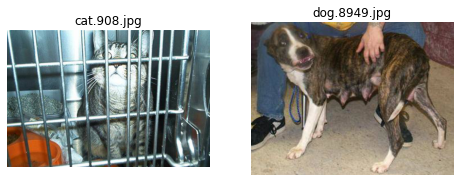

In [ ]:
# The images are in the data/shapes folder
data_path = '/content/drive/MyDrive/DL/5.CNN_HomeWork_HauTran/data/train/train'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

In [ ]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        transforms.Resize((256,256)),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    print(len(full_dataset))
    # Split into training (80% and testing (20%) datasets)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=100,
        num_workers=2,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=100,
        num_workers=2,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

25000
Data loaders ready


In [ ]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 16 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 16 input channels, and generates 16 outputs
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 16 inputs and generates 16 outputs
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # A four convolutional layer takes 16 inputs and generates 32 outputs
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 50% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.3)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 256/2/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 32 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 32, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))

        # Use a relu activation function after layer 3 (convolution 3 and pool)
        x = F.relu(self.pool(self.conv3(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv4(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 32)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/20000 (0%)] Loss: 0.695572
Training set [1000/20000 (5%)] Loss: 0.675121
Training set [2000/20000 (10%)] Loss: 0.679780
Training set [3000/20000 (15%)] Loss: 0.674776
Training set [4000/20000 (20%)] Loss: 0.690677
Training set [5000/20000 (25%)] Loss: 0.651247
Training set [6000/20000 (30%)] Loss: 0.631296
Training set [7000/20000 (35%)] Loss: 0.600673
Training set [8000/20000 (40%)] Loss: 0.668298
Training set [9000/20000 (45%)] Loss: 0.673030
Training set [10000/20000 (50%)] Loss: 0.672317
Training set [11000/20000 (55%)] Loss: 0.631395
Training set [12000/20000 (60%)] Loss: 0.659311
Training set [13000/20000 (65%)] Loss: 0.623782
Training set [14000/20000 (70%)] Loss: 0.593268
Training set [15000/20000 (75%)] Loss: 0.558847
Training set [16000/20000 (80%)] Loss: 0.571785
Training set [17000/20000 (85%)] Loss: 0.677700
Training set [18000/20000 (90%)] Loss: 0.579455
Training set [19000/20000 (95%)] Loss: 0.618562
Training set: Average loss: 0

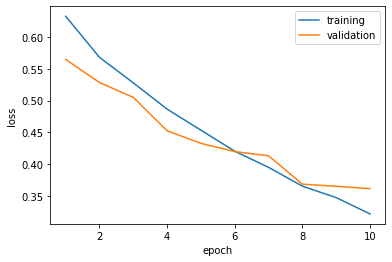

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
#metric
def get_metrics(y_test, y_pred):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred),'\n')
    print(classification_report(y_test, y_pred, digits=4), '\n')

Getting predictions from test set...
ACCURACY_SCORE:  0.8438
F1_SCORE:  0.8434
CONFUSION_MATRIX:
 [[1979  491]
 [ 290 2240]] 

              precision    recall  f1-score   support

           0     0.8722    0.8012    0.8352      2470
           1     0.8202    0.8854    0.8515      2530

    accuracy                         0.8438      5000
   macro avg     0.8462    0.8433    0.8434      5000
weighted avg     0.8459    0.8438    0.8435      5000
 



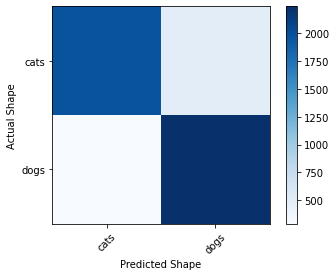

In [ ]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

get_metrics(truelabels,predictions )

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

In [ ]:
# Save the model weights
model_file = 'model/dog_vs_cat.pth'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as model/dog_vs_cat.pth


##7) Grid Search kiến trúc CNN dựa trên việc tổng quát hóa một thiết kế câu 6.

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        transforms.Resize((256,256)),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    print(len(full_dataset))
    # Split into training (80% and testing (20%) datasets)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=500,
        num_workers=2,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=500,
        num_workers=2,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

25000
Data loaders ready


In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    act_layers = {
        'relu': nn.ReLU(),
        'sigmoid': nn.Sigmoid(),
        'gelu': nn.GELU(),
    }

    in_features = 3
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 8, 24, 8)
        layers.append(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, stride=1, padding=1))
        layers.append(nn.MaxPool2d(kernel_size=2))
        act_type = trial.suggest_categorical("act_type", ['relu', 'sigmoid', 'gelu'])
        layers.append(act_layers[act_type])
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.6)
        layers.append(nn.Dropout(p))
        in_features = out_features
    layers.append(nn.Flatten())
    img_size = int(256/(2**n_layers))
    layers.append(nn.Linear(in_features=img_size * img_size * out_features, out_features=2))
    layers.append(nn.LogSoftmax(dim=1))
    return nn.Sequential(*layers)

In [ ]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)
BATCHSIZE = 500
EPOCHS = 5

N_TRAIN_EXAMPLES = BATCHSIZE * 40
N_VALID_EXAMPLES = BATCHSIZE * 10

def objective(trial):

    # Generate the model.
    model = define_model(trial).to( device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    # Generate the loss function
    criteria_name = trial.suggest_categorical("criterial", ['CrossEntropyLoss'])
    criteria_dict = {
        'CrossEntropyLoss': nn.CrossEntropyLoss(),
    }
    loss_criteria = criteria_dict[criteria_name]
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_criteria(output, target)

            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(device), target.to(device)
                
                output = model(data)
                # Calculate the accuracy for this batch
                _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

Training on cuda


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=3000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-27 07:14:30,427] A new study created in memory with name: no-name-96d61eb2-9601-4a9a-a5db-2b7cc289df53
[I 2022-02-27 08:19:42,435] Trial 0 finished with value: 0.0662 and parameters: {'n_layers': 1, 'n_units_l0': 24, 'act_type': 'gelu', 'dropout_l0': 0.4846389644089986, 'optimizer': 'SGD', 'lr': 0.000529199191253152, 'criterial': 'CrossEntropyLoss'}. Best is trial 0 with value: 0.0662.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.0662
  Params: 
    n_layers: 1
    n_units_l0: 24
    act_type: gelu
    dropout_l0: 0.4846389644089986
    optimizer: SGD
    lr: 0.000529199191253152
    criterial: CrossEntropyLoss


In [ ]:
model = define_model(trial).to( device)

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
loss_criteria = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=trial.params['lr'])
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 30 epochs
epochs = 10
for epoch in range(1, epochs + 1):
    print('Epoch: {}'.format(epoch))
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model,device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set [0/20000 (0%)] Loss: 0.634809
Training set [1000/20000 (5%)] Loss: 1.062110
Training set [2000/20000 (10%)] Loss: 0.680164
Training set [3000/20000 (15%)] Loss: 0.932023
Training set [4000/20000 (20%)] Loss: 0.849386
Training set [5000/20000 (25%)] Loss: 0.728017
Training set [6000/20000 (30%)] Loss: 0.728338
Training set [7000/20000 (35%)] Loss: 0.530572
Training set [8000/20000 (40%)] Loss: 0.661861
Training set [9000/20000 (45%)] Loss: 0.613514
Training set [10000/20000 (50%)] Loss: 0.800076
Training set [11000/20000 (55%)] Loss: 0.635556
Training set [12000/20000 (60%)] Loss: 0.579501
Training set [13000/20000 (65%)] Loss: 0.830268
Training set [14000/20000 (70%)] Loss: 0.757636
Training set [15000/20000 (75%)] Loss: 0.579862
Training set [16000/20000 (80%)] Loss: 0.632356
Training set [17000/20000 (85%)] Loss: 0.702975
Training set [18000/20000 (90%)] Loss: 0.704489
Training set [19000/20000 (95%)] Loss: 0.713705
Training set: Average loss: 0.791200
Validatio

Getting predictions from test set...
ACCURACY_SCORE:  0.6858
F1_SCORE:  0.6857
CONFUSION_MATRIX:
 [[1662  808]
 [ 763 1767]] 

              precision    recall  f1-score   support

           0     0.6854    0.6729    0.6791      2470
           1     0.6862    0.6984    0.6923      2530

    accuracy                         0.6858      5000
   macro avg     0.6858    0.6856    0.6857      5000
weighted avg     0.6858    0.6858    0.6857      5000
 



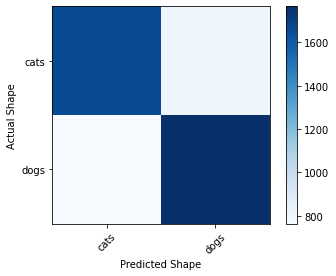

In [ ]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

get_metrics(truelabels,predictions )

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

##8) Huấn luyện lại mô hình bằng kiến trúc ResNet và MobileNet. Đánh giá chi phí tính toán và submit kết quả độ chính xác trên các ảnh thuộc folder test.

In [ ]:
from torchvision import *
net = models.resnet18(pretrained=True)
net = net.cuda() if device else net

In [ ]:
loss_criteria = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs
epochs = 5
for epoch in range(1, epochs + 1):
    print('Epoch: {}'.format(epoch))
    train_loss = train(net, device, train_loader, optimizer, epoch)
    test_loss = test(net,device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set [0/20000 (0%)] Loss: 0.056219
Training set [1000/20000 (5%)] Loss: 0.110859
Training set [2000/20000 (10%)] Loss: 0.080246
Training set [3000/20000 (15%)] Loss: 0.084772
Training set [4000/20000 (20%)] Loss: 0.049831
Training set [5000/20000 (25%)] Loss: 0.076905
Training set [6000/20000 (30%)] Loss: 0.076075
Training set [7000/20000 (35%)] Loss: 0.072232
Training set [8000/20000 (40%)] Loss: 0.126014
Training set [9000/20000 (45%)] Loss: 0.051834
Training set [10000/20000 (50%)] Loss: 0.049639
Training set [11000/20000 (55%)] Loss: 0.073101
Training set [12000/20000 (60%)] Loss: 0.082478
Training set [13000/20000 (65%)] Loss: 0.075104
Training set [14000/20000 (70%)] Loss: 0.070976
Training set [15000/20000 (75%)] Loss: 0.116122
Training set [16000/20000 (80%)] Loss: 0.096054
Training set [17000/20000 (85%)] Loss: 0.093026
Training set [18000/20000 (90%)] Loss: 0.066980
Training set [19000/20000 (95%)] Loss: 0.075107
Training set: Average loss: 0.074939
Validatio

Getting predictions from test set...
ACCURACY_SCORE:  0.9852
F1_SCORE:  0.9852
CONFUSION_MATRIX:
 [[2441   29]
 [  45 2485]] 

              precision    recall  f1-score   support

           0     0.9819    0.9883    0.9851      2470
           1     0.9885    0.9822    0.9853      2530

    accuracy                         0.9852      5000
   macro avg     0.9852    0.9852    0.9852      5000
weighted avg     0.9852    0.9852    0.9852      5000
 



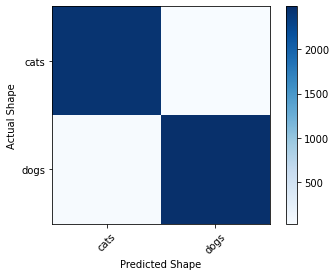

In [ ]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
net.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in net.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

get_metrics(truelabels,predictions )

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

In [ ]:
from torchvision import *
net = models.mobilenet_v2()
net = net.cuda() if device else net
net

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
loss_criteria = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs
epochs = 5
for epoch in range(1, epochs + 1):
    print('Epoch: {}'.format(epoch))
    train_loss = train(net, device, train_loader, optimizer, epoch)
    test_loss = test(net,device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set [0/20000 (0%)] Loss: 6.966485
Training set [1000/20000 (5%)] Loss: 6.576194
Training set [2000/20000 (10%)] Loss: 5.777911
Training set [3000/20000 (15%)] Loss: 4.921817
Training set [4000/20000 (20%)] Loss: 4.011234
Training set [5000/20000 (25%)] Loss: 3.166701
Training set [6000/20000 (30%)] Loss: 2.449597
Training set [7000/20000 (35%)] Loss: 1.870139
Training set [8000/20000 (40%)] Loss: 1.512764
Training set [9000/20000 (45%)] Loss: 1.266389
Training set [10000/20000 (50%)] Loss: 1.073783
Training set [11000/20000 (55%)] Loss: 0.976685
Training set [12000/20000 (60%)] Loss: 0.920705
Training set [13000/20000 (65%)] Loss: 0.879931
Training set [14000/20000 (70%)] Loss: 0.862804
Training set [15000/20000 (75%)] Loss: 0.805545
Training set [16000/20000 (80%)] Loss: 0.787393
Training set [17000/20000 (85%)] Loss: 0.771894
Training set [18000/20000 (90%)] Loss: 0.755111
Training set [19000/20000 (95%)] Loss: 0.760977
Training set: Average loss: 2.217374
Validatio

In [ ]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
net.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in net.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

get_metrics(truelabels,predictions )

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

##9) Thử nghiệm các phương pháp Augmentation như Flip, Rotation, Random Crop, Bright Contrast để cải thiện kết quả mô hình.

In [ ]:
from torchvision.transforms.transforms import ToTensor
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        transforms.Resize((256,256)),
        
        transforms.RandomCrop(size=(256, 256)),
        transforms.RandomRotation(degrees=(0, 90)),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomHorizontalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    print(len(full_dataset))
    # Split into training (80% and testing (20%) datasets)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=100,
        num_workers=2,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=100,
        num_workers=2,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

##10) Lập bảng kết quả các thử nghiệm đã sử dụng.

In [ ]:
import pandas as pd
result = pd.read_csv("result.csv")
result

,Models,Custom CNN,Grid Search CNN,ResNet,MobileNet
0,Accuracy(%),84.38,68.58,98.52,62.32
